In [2]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader

# Performance measure
from ignite.metrics import SSIM
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

# 3D-UNet model
from pytorch3dunet.unet3d import model

from train_utils import predictions, LoadData

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.set_default_dtype(torch.float32) 

Device: cuda


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Plotting loss

During training, both the training and validation loss for each model was stored for each epoch and saved after training. Plotting all losses in subplots for easier visualization.

All of the losses were saved in a separate folder, 'losses', with a filename corresponding to the current hyperparameter. All files containing training loss has a filename that starts with 'train' and similar for the validation loss with 'val'.

In [22]:
loss_path = './3D_model_weights/losses'

train_losses = []
val_losses = []

# Looping through all files in the folder specified by the path
for filename in os.listdir(loss_path):
    if filename.startswith('train'):
        loss_file = os.path.join(loss_path, filename)

        # Reading the file containing training loss
        with open(loss_file, 'r') as file:
            data = json.load(file)

            # Filename contains hyperparameters. Extracting the correct hyperparameters to differentiate between different losses
            current_hyperparams = 'Train '+ filename[17:-10]
            train_losses.append({
                current_hyperparams: data
            })

    elif filename.startswith('val'):
        loss_file = os.path.join(loss_path, filename)
        with open(loss_file, 'r') as file:
            data = json.load(file)
            current_hyperparams = 'Validation '+ filename[15:-5] 
            val_losses.append({
                current_hyperparams: data
            })

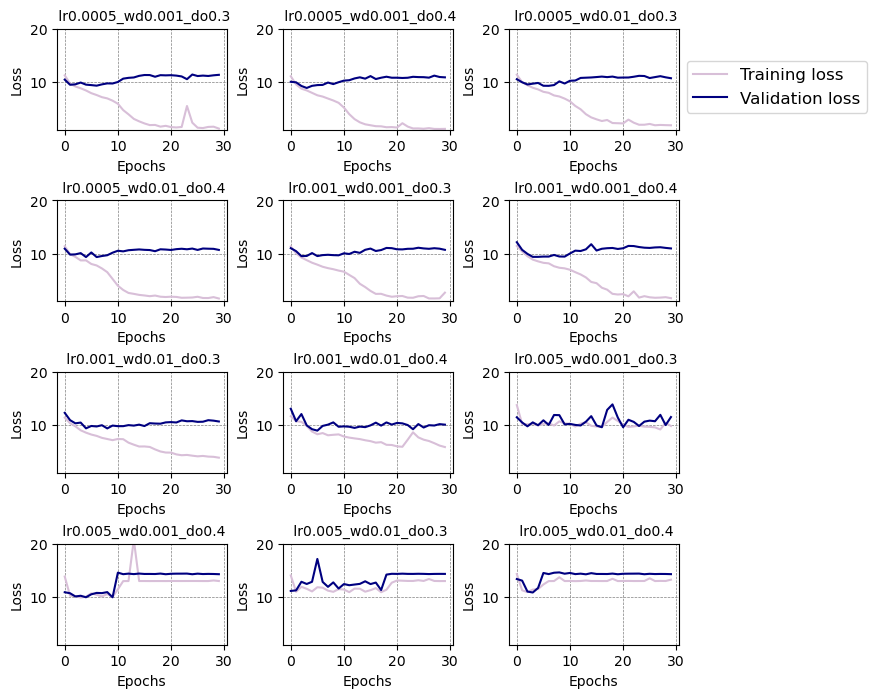

In [24]:
x_values = np.arange(0,30)
fig, axes = plt.subplots(4,3, figsize=(10,8))

axes = axes.flatten()

for i in range(12):
    train_element = list(train_losses[i].values())[0]
    val_element = list(val_losses[i].values())[0]
    axes[i].plot(x_values, train_element, color = 'thistle')
    axes[i].plot(x_values, val_element, color = 'navy')
    axes[i].set_title(f'{list(train_losses[i].keys())[0][5:]}', fontsize=10)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].set_ylim(1,20)
    axes[i].set_aspect('equal')
    axes[i].grid(True, color='gray', linestyle = '--', lw=0.5)

fig.legend(['Training loss', 'Validation loss'], bbox_to_anchor = (1.02,0.85) ,loc='upper right', fontsize=12, frameon=True, markerscale=1.5)
plt.subplots_adjust( hspace=0.7, wspace=-0.3)
plt.show()

### Finding the model with the lowest validation loss

The results-file is a list with 30 elements, one of each epoch in the training. Each element is a dictionary, conaining information about the results. During training, the validation loss was saved for each epoch, in addition to the current hyperparameters. To determine the overall lowest loss, the last loss value for each model, in addition to the corresponding hyperparameters were found, and the lowest value gets printed.

In [ ]:
results_path = './3D_model_weights/results'

all_results = []

for filename in os.listdir(results_path):
    if filename.endswith('.json'):
        results_file = os.path.join(results_path, filename)
        with open(results_file, 'r') as file:
            data = json.load(file)
            num_models = len(data) // 30 # number of epochs
            for i in range(num_models):
                run = data[i*30 : (i+1)*30]
                all_results.append({
                    'loss': run[-1]['loss'], # Use the validation loss from the final epoch
                    'learning rate': run[-1]['learning rate'],
                    'weight decay': run[-1]['weight decay'],
                    'drop out': run[-1]['drop out']
                    })


best_result = min(all_results, key=lambda d: d['loss'])
print(f'Model with the lowest loss: {best_result}')

Model with the lowest loss: {'loss': 10.104728386952328, 'learning rate': 0.001, 'weight decay': 0.01, 'drop out': 0.4}


### Model selection
The best performing model was determined based on how each model performed on the evaluation metrics. SSIM, MSE and MAE was therefore calculated on predictions from validation data for all models. During training, the weights for each model were saved. Initializing the 3D-UNet with the weights to get predictions on validation data.

In [ ]:
# Loading validation data

val_img_path = '../Preprocessing/preprocessed_img_val'
val_kspace_path = '../Preprocessing/preprocessed_kspace_val'

val_data = LoadData(val_kspace_path, val_img_path, datatype='val')

set_seed(42)
batch_size = 1
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))


In [ ]:

def calc_MAE(preds, label):
    mae = MeanAbsoluteError()
    return mae(preds, label)

def calc_MSE(preds, label):
    mse = MeanSquaredError()
    return mse(preds, label)


def calc_SSIM_eval(preds, true):
    metric = SSIM(data_range=1)
    metric.update((preds, true))
    ssim_value = metric.compute()
    return ssim_value


### Validation scores

Predictions were generated on all 52 time slices for the 3D volumes. The average MAE, MSE and SSIM of all time slices gets printed for each model.

In [ ]:

def validation_scores(weights_file):
    """ 
    Calculating the evaluation metrics for each model.

    Parameters:
    - weights_file: Path to the saved weight for each model

    Returns:
    None. The evaluation values for each model gets printed.
    """

    model_eval = model.UNet3D(in_channels=2, out_channels=1, num_groups=8, is_segmentation=False)

    checkpoint = torch.load(weights_file, map_location=device, weights_only=True)

    # Initializing the model with the saved weights.
    model_eval.load_state_dict(checkpoint['model_state_dict'])

    model_eval.eval()
    set_seed(42)
    batch_size = 1
    # Creating a dataloader for validation loader.
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))

    model_eval.to(device=device)

    # Generating predictions on validation data
    preds, true = predictions(model_eval, val_loader)

    ssim_values = []
    mse_values = []
    mae_values = []

    # Looping over the number of time points (52) in predictions
    for i in range(len(preds)):
        # Moving the tensors from GPU to CPU
        preds_cpu = preds[i].cpu()
        true_cpu = true[i].cpu()

        # Removing the channel-dimension
        preds0= preds_cpu.squeeze(0)
        true0= true_cpu.squeeze(0)

        ssim_values.append(calc_SSIM_eval(preds0, true0))
        mse_values.append(calc_MSE(preds0, true0))
        mae_values.append(calc_MAE(preds0, true0))

    # Computing the mean value over the 52 predictions (number of time points)
    ssim_val = np.mean(ssim_values)
    mse_val = np.mean(mse_values)
    mae_val = np.mean(mae_values)

    # Printing the name of the model (from filename)
    print(f'Model {weights_file[19:37]}') 

    print(f'SSIM: {ssim_val}')
    print(f'MSE: {mse_val}')
    print(f'MAE: {mae_val}')

    print('---------------')

#### Folder structure description
All weights saved during training were saved within different subfolders in the '3D_model_weights' folder. That folder contains multiple folders where the filename is the hyperparameter combination for the model. The script below accesses the correct folders and extracts the correct weights. All epoch checkpoints were saved during training for safety measures - in case training needed to be resumed. However, only the last epoch is evaluated during model evaluation.

In [ ]:
root_dir = './3D_model_weights'

all_weights = []

for folder in os.listdir(root_dir):

    # All hyperparameter combinations starts with 'lr'
    if folder.startswith('lr'):
        folder_path = os.path.join(root_dir, folder)
        for filename in os.listdir(folder_path):

            # All weights filenames ends with 'epoch30.pth' as only the fully trained model will be used for evaluation
            if filename.endswith('epoch30.pth'):
                full_path = os.path.join(folder_path, filename)
                all_weights.append(full_path)


In [32]:
for weight in all_weights:
    validation_scores(weight)

C:\Users\Caroline\AppData\Local\Temp\ipykernel_20844\3755693864.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
C:\Users\Caroline\AppData

Model lr1e-3_wd1e-2_do03
SSIM: 0.6175303329440699
MSE: 0.007531764917075634
MAE: 0.054549071937799454
---------------
Model lr1e-3_wd1e-2_do04
SSIM: 0.6455511442888446
MSE: 0.007074242457747459
MAE: 0.05278028920292854
---------------
Model lr1e-3_wd1e-3_do03
SSIM: 0.5924688910570199
MSE: 0.008093632757663727
MAE: 0.05695722997188568
---------------
Model lr1e-3_wd1e-3_do04
SSIM: 0.6014601573521414
MSE: 0.007292451336979866
MAE: 0.054579511284828186
---------------
Model lr5e-3_wd1e-2_do03
SSIM: 0.5964850100593109
MSE: 0.02834748476743698
MAE: 0.09366545081138611
---------------
Model lr5e-3_wd1e-2_do04
SSIM: 0.5961533421440851
MSE: 0.02801096811890602
MAE: 0.09304770827293396
---------------
Model lr5e-3_wd1e-3_do03
SSIM: 0.5962069118674108
MSE: 0.027976535260677338
MAE: 0.09313622862100601
---------------
Model lr5e-3_wd1e-3_do04
SSIM: 0.5960893753246101
MSE: 0.027912188321352005
MAE: 0.0929342582821846
---------------
Model lr5e-4_wd1e-2_do03
SSIM: 0.6126418052529675
MSE: 0.00715694

### Visual selection

Two models recieved better evaluation scores than the others. Using visual selection to determine the best model by plotting the predictions of the two best performing models.

In [ ]:
model2 = model.UNet3D(in_channels=2, out_channels=1, num_groups=8, is_segmentation=False)

checkpoint = torch.load('./3D_model_weights/lr1e-3_wd1e-2_do04/model_lr0.001_wd0.01_do0.4_epoch30.pth', map_location=device, weights_only=True)


model2.load_state_dict(checkpoint['model_state_dict'])

model2.eval()

model2.to(device=device)
pred2, true2 = predictions(model2, val_loader)

preds_cpu2 = pred2[0].cpu()
true_cpu2 = true2[0].cpu()
preds22= preds_cpu2.squeeze(0,1)
true22= true_cpu2.squeeze(0,1)

C:\Users\Caroline\AppData\Local\Temp\ipykernel_5352\3755693864.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
C:\Users\Caroline\AppData\

In [ ]:
model12 = model.UNet3D(in_channels=2, out_channels=1, num_groups=8, is_segmentation=False)

checkpoint = torch.load('./3D_model_weights/lr5e-4_wd1e-3_do04/model_lr0.0005_wd0.001_do0.4_epoch30.pth', map_location=device, weights_only=True)

# Only load the model state dict from the checkpoint
model12.load_state_dict(checkpoint['model_state_dict'])

model12.eval()

model12.to(device=device)
pred12, true12 = predictions(model12, val_loader)

preds_cpu12 = pred12[0].cpu()
true_cpu12 = true12[0].cpu()
preds1212= preds_cpu12.squeeze(0,1)
true1212= true_cpu12.squeeze(0,1)

C:\Users\Caroline\AppData\Local\Temp\ipykernel_5352\3755693864.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
C:\Users\Caroline\AppData\

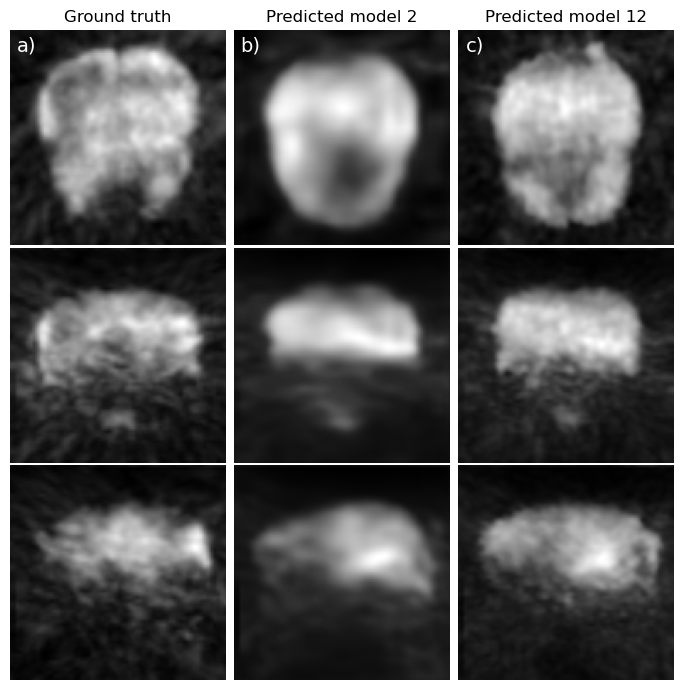

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize =(7,7))

# Selecting slice 82 in all three dimensions
i = 82

ax[0,0].imshow(np.rot90(true22[:,:,i]), cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')
ax[0,0].text(15,3,'a)', ha='right', va='top', fontsize=14, color='white')

ax[0,1].imshow(np.rot90(preds22[:,:,i]), cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('Predicted model 2')
ax[0,1].text(15,3,'b)', ha='right', va='top', fontsize=14, color='white')

ax[0,2].imshow(np.rot90(preds1212[:,:,i]), cmap='gray')
ax[0,2].axis('off')
ax[0,2].set_title('Predicted model 12')
ax[0,2].text(15,3,'c)', ha='right', va='top', fontsize=14, color='white')

ax[1,0].imshow(np.rot90(true22[:,i,:]), cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(np.rot90(preds22[:,i,:]), cmap='gray')
ax[1,1].axis('off')
ax[1,2].imshow(np.rot90(preds1212[:,i,:]), cmap='gray')
ax[1,2].axis('off')

ax[2,0].imshow(np.rot90(true22[i,:,:]), cmap='gray')
ax[2,0].axis('off')
ax[2,1].imshow(np.rot90(preds22[i,:,:]), cmap='gray')
ax[2,1].axis('off')
ax[2,2].imshow(np.rot90(preds1212[i,:,:]), cmap='gray')
ax[2,2].axis('off')
plt.tight_layout()

plt.subplots_adjust( hspace=0.01, wspace=0.01)
plt.show()

### Enhanced loss plot of the selected model

In [13]:
lowst_train = list(train_losses[9].values())[0] # model selected based on MSE
lowst_val = list(val_losses[9].values())[0]

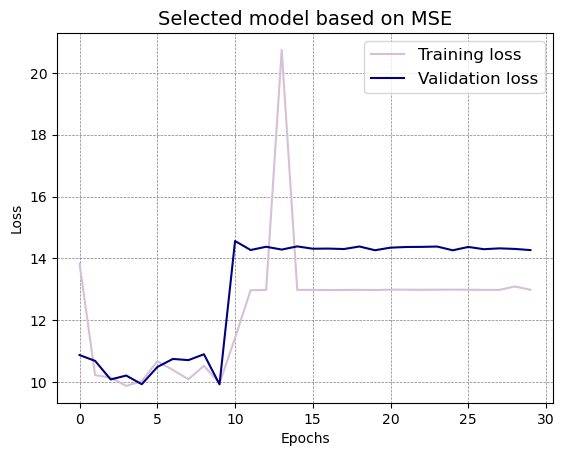

In [16]:
plt.plot(x_values, lowst_train, color = 'thistle', label = 'Training loss')
plt.plot(x_values, lowst_val, color = 'navy', label = 'Validation loss')
plt.grid(True, color='gray', linestyle = '--', lw=0.5)
plt.legend(loc='upper right', fontsize=12, frameon=True, markerscale=1.5)
plt.title('Selected model based on MSE', fontsize=14)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()